In [1]:
import numpy as np
import cv2
import skimage.io as skio
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn

In [39]:
def dataloader(image, N=10000):
    H, W = image.shape[:2]
    u = np.random.choice(H, size=(N, 1))
    v = np.random.choice(W, size=(N, 1))
    outputs = image[u, v].reshape((N, 3))
    inputs_normalized = np.hstack((u / H, v / W)).astype(np.float32)
    return inputs_normalized, outputs

In [ ]:
def input_generator(inputs_yx, L=10):
    inputs_y = inputs_yx[:, 0]
    inputs_x = inputs_yx[:, 1]
    coefficients_vector = np.array([2 ** exp for exp in range(L)]) * np.pi
    sinusoidal_inputs_y = np.outer(inputs_y, coefficients_vector)
    sinusoidal_inputs_x = np.outer(inputs_x, coefficients_vector)

    sin_y = np.sin(sinusoidal_inputs_y)
    cos_y = np.cos(sinusoidal_inputs_y)
    sin_x = np.sin(sinusoidal_inputs_x)
    cos_x = np.cos(sinusoidal_inputs_x)

    res = np.hstack((sin_y, cos_y, sin_x, cos_x, np.reshape(inputs_y, (len(inputs_y), 1)), np.reshape(inputs_x, (len(inputs_x), 1))))

    return res.astype(np.float32)

In [102]:
def get_full_image(model, H, W, L=10):
    curr_image_rows = []
    for i in range(H):
        inputs = np.array([[i / H, j / W] for j in range(W)])
        inputs_with_pe = input_generator(inputs, L)
        model_input = torch.from_numpy(inputs_with_pe)
        y_pred = model(model_input).detach().numpy()
        curr_image_rows.append(y_pred.reshape(1, W, 3))
    return np.vstack(tuple(curr_image_rows))

In [194]:
# Load image
image = skio.imread("data/1/2.jpg")
image = (image / 255).astype(np.float32)

In [195]:
# Configurations
num_iters = 3000
N = 10000
L = 20
W = 256
lr = 1e-2

In [196]:
model = nn.Sequential(
    nn.Linear(4 * L + 2, W),
    nn.ReLU(),
    nn.Linear(W, W),
    nn.ReLU(),
    nn.Linear(W, W),
    nn.ReLU(),
    nn.Linear(W, 3),
    nn.Sigmoid()
)
model = model.to('cpu')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [198]:
psnrs = []
images = []
iterations_to_record = {0, 50, 150, 500, 1000, 2000}
for iter in range(num_iters):
    positions_normalized, pixel_values = dataloader(image, N)
    x = torch.from_numpy(input_generator(positions_normalized, L)).to('cpu')
    y = torch.from_numpy(pixel_values).to('cpu')
    
    optimizer.zero_grad()

    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

    psnrs.append(10 * np.log10(1 / loss.item()))

    if iter % 100 == 0:
        print(f"iteration {iter}: PSNR is {psnrs[-1]}")
    
    if iter in iterations_to_record:
        with torch.no_grad():
            res_image = get_full_image(model, 1285, 1714, L)
            images.append(res_image)

iteration 0: PSNR is 12.939911226791892
iteration 100: PSNR is 27.09684774570658
iteration 200: PSNR is 29.679611493452803
iteration 300: PSNR is 30.544138512493
iteration 400: PSNR is 31.741965003724275
iteration 500: PSNR is 31.849999788887636
iteration 600: PSNR is 32.23238994171708
iteration 700: PSNR is 32.3554875431777
iteration 800: PSNR is 32.495954893393346
iteration 900: PSNR is 32.688518751574016
iteration 1000: PSNR is 32.29255623609063
iteration 1100: PSNR is 32.92047149654532
iteration 1200: PSNR is 33.10283557006771
iteration 1300: PSNR is 33.14343023189482
iteration 1400: PSNR is 33.42223846372272
iteration 1500: PSNR is 33.14883189681706
iteration 1600: PSNR is 33.40773343511519
iteration 1700: PSNR is 33.656701850908036
iteration 1800: PSNR is 33.95147473936109
iteration 1900: PSNR is 33.43433253833825
iteration 2000: PSNR is 33.66652622473742
iteration 2100: PSNR is 33.41664787175192
iteration 2200: PSNR is 33.82022246949647
iteration 2300: PSNR is 33.53457148741472


In [154]:
with torch.no_grad():
    res_image = get_full_image(model, 689, 1024, 20)

/var/folders/zd/6l9_l17d02d4msw14wpqz0lw0000gn/T/ipykernel_17793/3163708670.py:1: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.imshow(images[5])


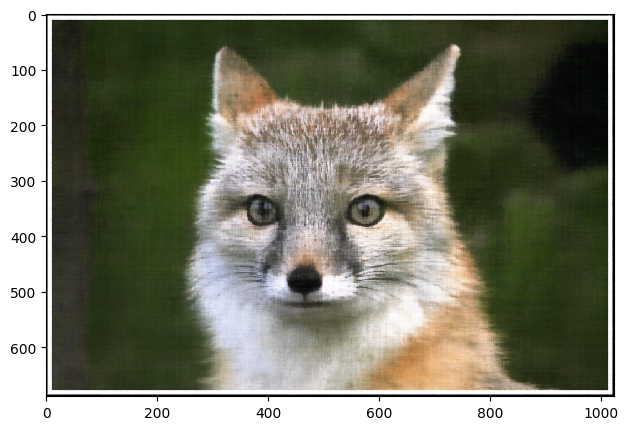

In [167]:
skio.imshow(images[5])

In [204]:
skio.imsave("data/1/progress_per_epoch/2_5.jpg", (images[5] * 255).astype(np.uint8))

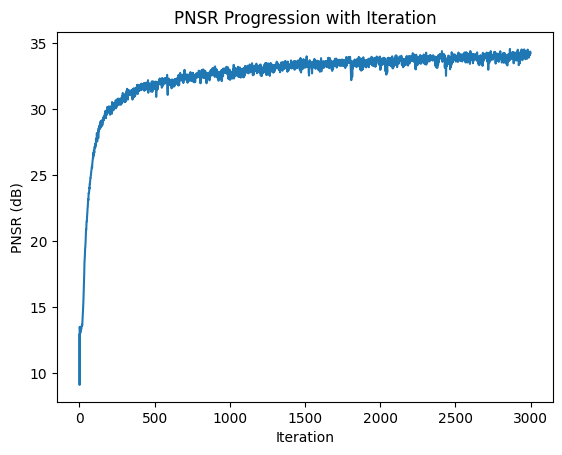

In [205]:
plt.plot(psnrs)
plt.xlabel("Iteration")
plt.ylabel("PNSR (dB)")
plt.title("PNSR Progression with Iteration")
plt.show()

(-0.5, 1713.5, 1284.5, -0.5)

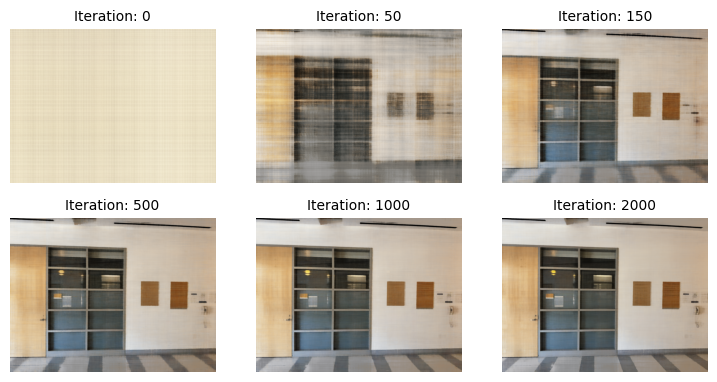

In [206]:
fig, axes = plt.subplots(2, 3, figsize=(9, 4.5))

axes[0][0].imshow(images[0])
axes[0][0].set_title("Iteration: 0", fontsize=10)
axes[0][0].axis('off')

axes[0][1].imshow(images[1])
axes[0][1].set_title("Iteration: 50", fontsize=10)
axes[0][1].axis('off')

axes[0][2].imshow(images[2])
axes[0][2].set_title("Iteration: 150", fontsize=10)
axes[0][2].axis('off')

axes[1][0].imshow(images[3])
axes[1][0].set_title("Iteration: 500", fontsize=10)
axes[1][0].axis('off')

axes[1][1].imshow(images[4])
axes[1][1].set_title("Iteration: 1000", fontsize=10)
axes[1][1].axis('off')

axes[1][2].imshow(images[5])
axes[1][2].set_title("Iteration: 2000", fontsize=10)
axes[1][2].axis('off')